In [6]:
#importing all libraries and packages that are used 
import pandas as pd
import pvlib
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import scipy
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['font.size']=12
plt.rcParams['lines.linewidth']=1.25
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12
plt.rcParams['axes.titlesize']=12

In [2]:
"""
import csv files of monthly data
NOTE: could also use lines in SQLQuery notebook to import data and immediately start analyzing it, without ever saving locally & creating a csv
csv files were created here so there would be a static dataset and the output would be reproducable

"""
names = ['dbo.sqlt_data_1_2023_01_onemin.csv','dbo.sqlt_data_1_2023_02_onemin.csv','dbo.sqlt_data_1_2023_03_onemin.csv','dbo.sqlt_data_1_2023_04_onemin.csv','dbo.sqlt_data_1_2023_05_onemin.csv',
         'dbo.sqlt_data_1_2023_06_onemin.csv','dbo.sqlt_data_1_2023_07_onemin.csv','dbo.sqlt_data_1_2023_08_onemin.csv','dbo.sqlt_data_1_2023_09_onemin.csv',
         'dbo.sqlt_data_1_2023_10_onemin.csv','dbo.sqlt_data_1_2023_11_onemin.csv','dbo.sqlt_data_1_2022_12_onemin.csv']
data = []
for name in names:
    x = pd.read_csv(name)
    data.append(x)

In [143]:
#join all the data together in one df, convert that dataframe to have a datetimeindex & make it timezone aware
annual_onemin = pd.concat(data)
annual_onemin.index = pd.to_datetime(annual_onemin['TmStamp'], utc=True)
annual_onemin.index = annual_onemin.index.tz_convert('America/Chicago')
annual_onemin['month'] = annual_onemin.index.month
annual_onemin['min'] = annual_onemin.index.minute

In [144]:
#calculate elevation and azimuth with pvlib's solarposition function & save to df for use in filtering and analysis
annual_onemin['Azimuth'] = pvlib.solarposition.get_solarposition(annual_onemin.index, 30, -92)['azimuth']
annual_onemin['Elevation'] = pvlib.solarposition.get_solarposition(annual_onemin.index, 30, -92)['elevation']

In [145]:
#filter out datapoints that are beyond reasonable elevation or out of range with physically possible values of irradiance or temperature
annual_onemin = annual_onemin.where((annual_onemin['Elevation'] > 0) & (annual_onemin['Elevation'] < 90))
irrads = ['weatherstation/diffused','weatherstation/globalirradiance','weatherstation/direct normal','weatherstation/planeofarray']
for irrad in irrads:
    annual_onemin[irrad] = annual_onemin[irrad].where((annual_onemin[irrad] < 1200) & (annual_onemin[irrad] > 0))
annual_onemin['weatherstation/temperaturec'] = annual_onemin['weatherstation/temperaturec'].where((annual_onemin['weatherstation/temperaturec'] < 45) & (annual_onemin['weatherstation/temperaturec'] > -10))

Text(0, 0.5, 'weatherstation/temperaturec (℃)')

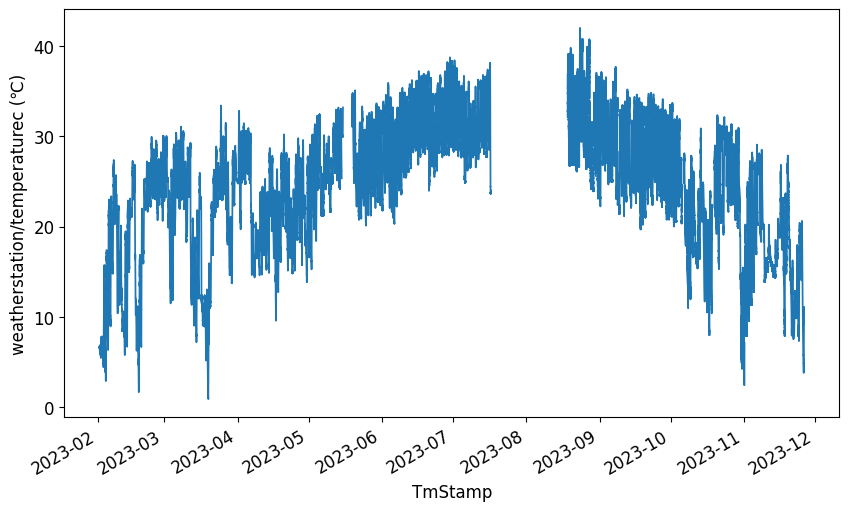

In [18]:
"""
parameter run plot
shows the parameter of interest plotted over time
viewing the data this way, gaps and extreme outliers are immediately identified
"""

param = 'weatherstation/temperaturec' #-----------------> change this value to any another df column name, like 'weatherstation/wind direction'
annual_onemin[param].plot()
plt.ylabel((str(param)+str(' (℃)'))) #-----------------> the units will change depending on what is being plotted

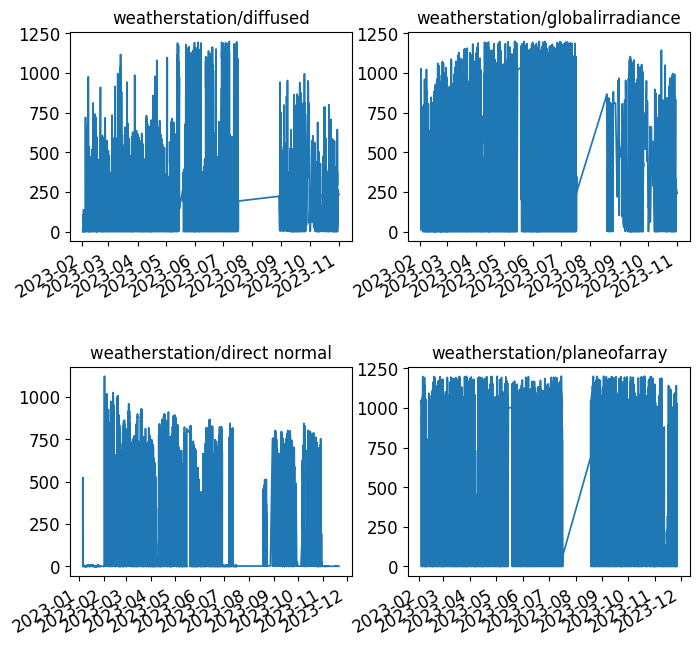

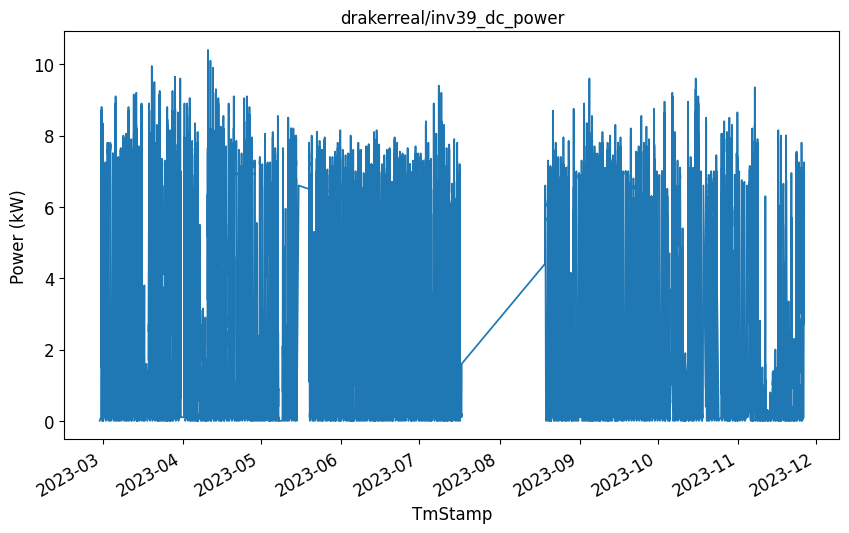

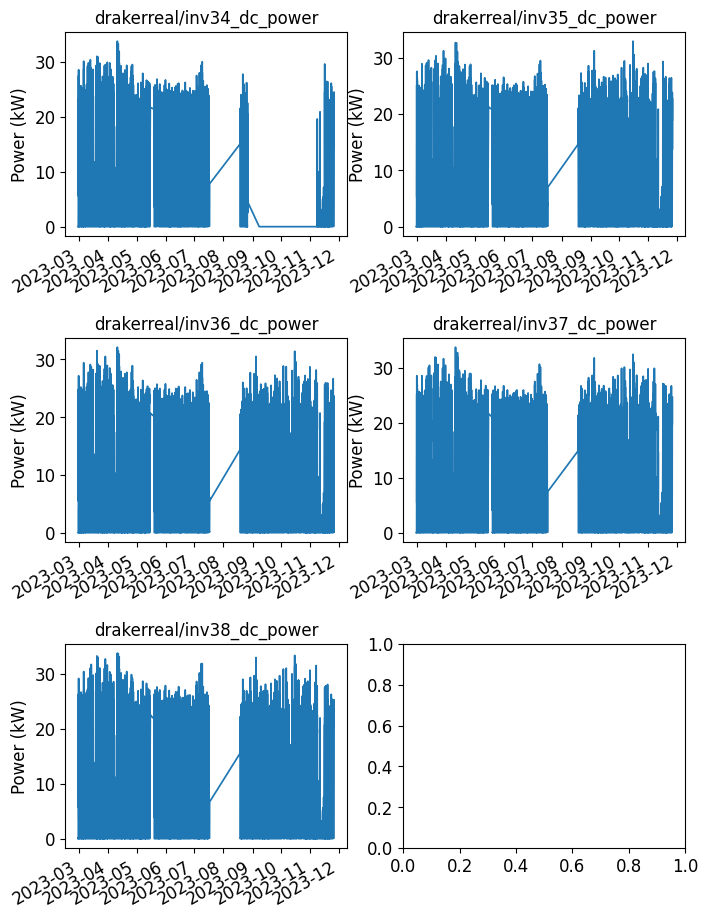

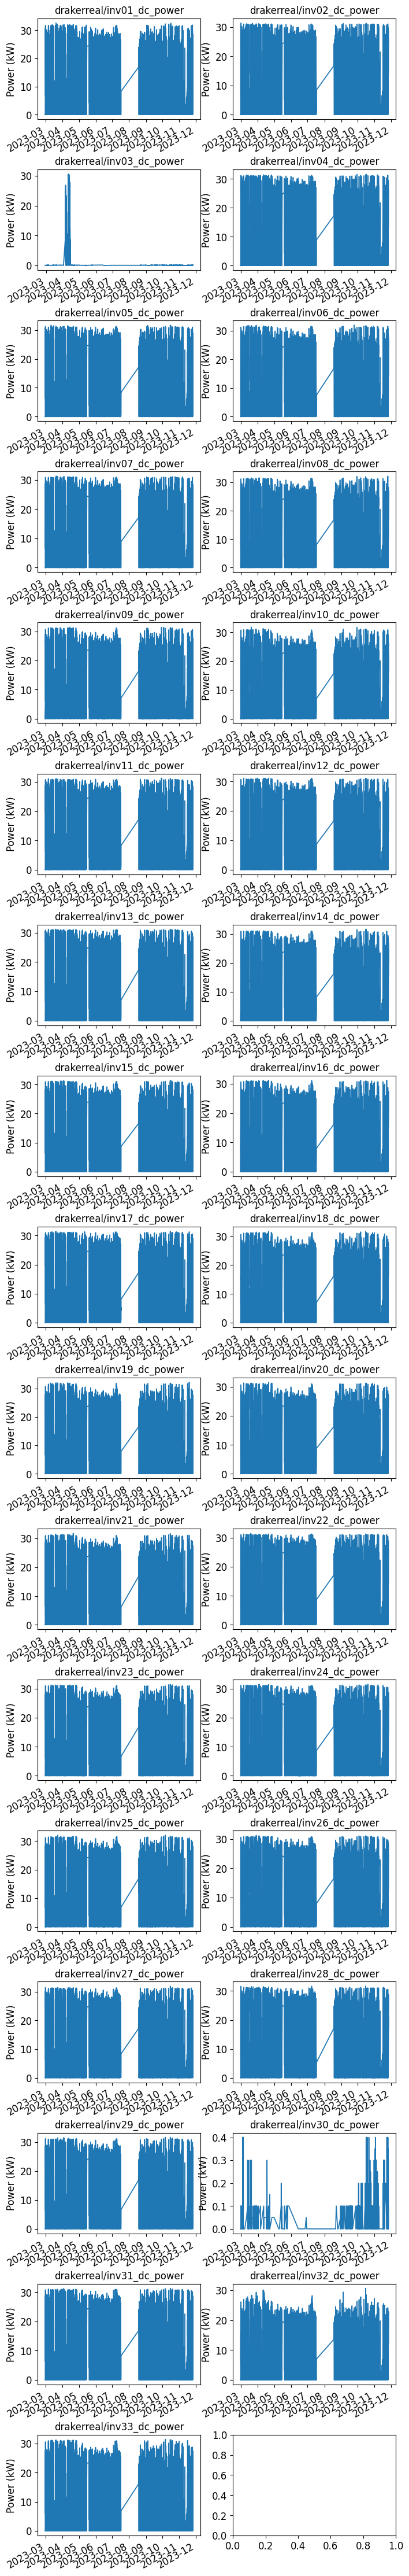

In [75]:
"""
parameter run plot - all inverters
this cell creates a run plot for every inverter + irradiance values

"""

inv_p = ['01','02','03','04','05','06','07','08','09', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',
       '27', '28', '29', '30', '31', '32', '33']
inv_m = ['34','35','36','37','38']
inv_tf = ['39']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize = (8,8))
plt.subplots_adjust(hspace=0.6)
for irrad, ax in zip(irrads, axs.ravel()):
    annual_onemin[irrad].dropna().plot(ax=ax)
    ax.set_title(irrad)
    ax.set_ylabel("")
    ax.set_xlabel("")
plt.savefig('weathstat.png', bbox_inches='tight')
plt.show()


annual_onemin['drakerreal/inv39_dc_power'].dropna().plot()
plt.title('drakerreal/inv39_dc_power')
plt.ylabel('Power (kW)')
plt.savefig('invtf.png', bbox_inches='tight')


fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (8,12))
plt.subplots_adjust(hspace=0.5)
for inv, ax in zip(inv_m, axs.ravel()):
    annual_onemin['drakerreal/inv'+inv+'_dc_power'].dropna().plot(ax=ax)
    ax.set_title('drakerreal/inv'+inv+'_dc_power')
    ax.set_ylabel('Power (kW)')
    ax.set_xlabel("")
plt.savefig('invm.png', bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(nrows=17, ncols=2, figsize = (8,64))
plt.subplots_adjust(hspace=0.5)
for inv, ax in zip(inv_p, axs.ravel()):
    annual_onemin['drakerreal/inv'+inv+'_dc_power'].dropna().plot(ax=ax)
    ax.set_title('drakerreal/inv'+inv+'_dc_power')
    ax.set_ylabel('Power (kW)')
    ax.set_xlabel("")
plt.savefig('invp.png', bbox_inches='tight')
plt.show()

Text(0.5, 0, 'Time')

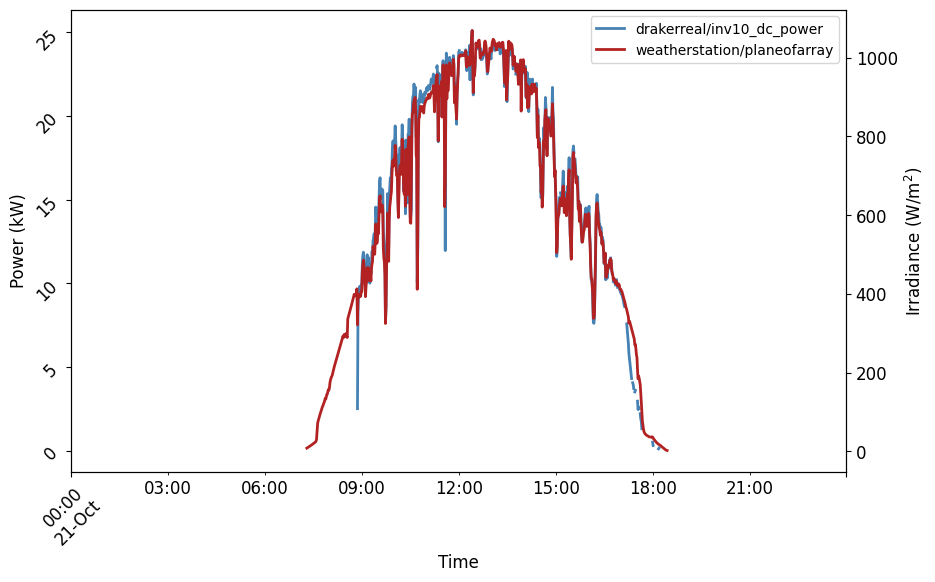

In [46]:
#diurnal plot - assuming two different unit parameters - can change parameters to any column in the df
date = '2023-10-21' #----------------------------------> change date here
param_1 = 'drakerreal/inv10_dc_power'#-----------------> first parameter of interest
param_2 = 'weatherstation/planeofarray'#---------------> second parameter of interest

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
annual_onemin.loc[date, param_1].plot(ax=ax1, label=param_1, linewidth=2, color='steelblue', zorder=5.5)
annual_onemin.loc[date, param_2].plot(ax=ax2, label=param_2, linewidth=2, color='firebrick', zorder=5.5)

line_1 = Line2D([0], [0], color='steelblue', linewidth=2, linestyle='-',label=param_1)
line_2 = Line2D([0], [0], color='firebrick', linewidth=2, linestyle='-',label=param_2)
lines = [line_1,line_2]
plt.legend(prop=dict(size='small'),handles=lines)
ax1.set_ylabel('Power (kW)') #-------------------------> these will need to be changed depending on what is being plotted - this is ax1 so should be units for param_1
ax1.tick_params(labelrotation=45)
ax2.set_ylabel('Irradiance (W/m$^2$)')#----------------> these will need to be changed depending on what is being plotted - this is ax2 so should be units for param_2
ax1.set_xlabel('Time')

Text(0.5, 0, 'Time')

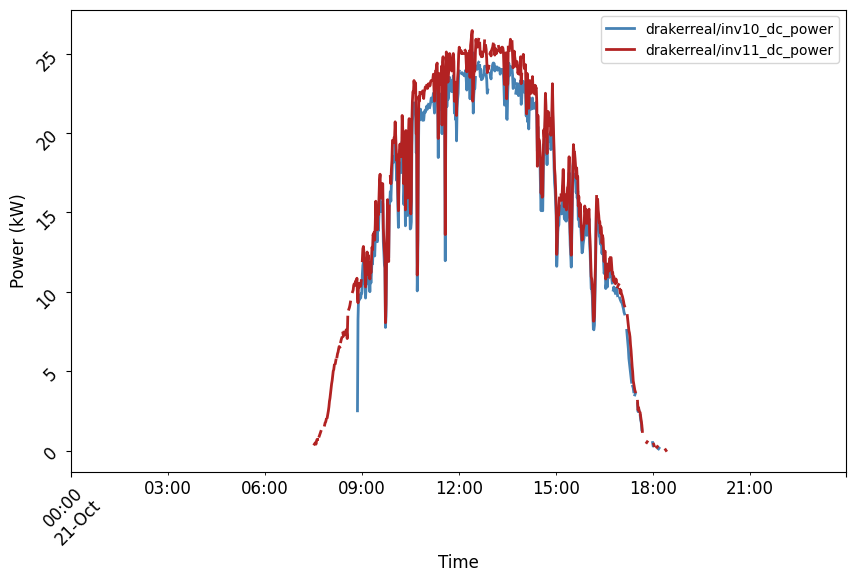

In [54]:
#diurnal plot - assuming two same unit parameters - - can change parameters to any column in the df

date = '2023-10-21' #----------------------------------> change date here
param_1 = 'drakerreal/inv10_dc_power'#-----------------> first parameter of interest
param_2 = 'drakerreal/inv11_dc_power'#---------------> second parameter of interest

fig, ax = plt.subplots()
annual_onemin.loc[date, param_1].plot(ax=ax, label=param_1, linewidth=2, color='steelblue', zorder=5.5)
annual_onemin.loc[date, param_2].plot(ax=ax, label=param_2, linewidth=2, color='firebrick', zorder=5.5)

ax.legend(prop=dict(size='small'))
ax.tick_params(labelrotation=45)
ax.set_ylabel('Power (kW)') #----------------------> these will need to be changed depending on what is being plotted
ax.set_xlabel('Time')

Text(0, 1200, '40.2821x + 35.3904')

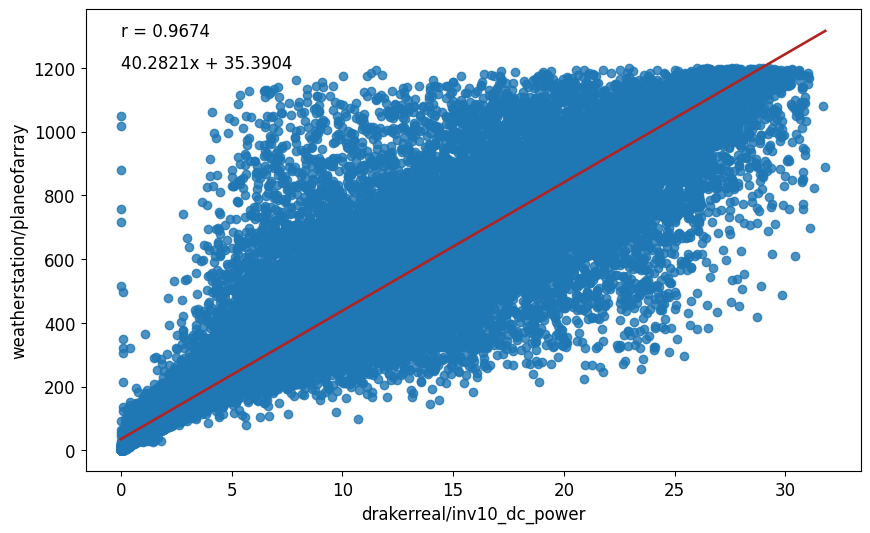

In [68]:
#plotting two parameters to observe correlation - can change parameters to any column in the df
param_1 = 'drakerreal/inv10_dc_power'#-----------------> first parameter of interest
param_2 = 'weatherstation/planeofarray'#---------------> second parameter of interest

slope, intercept, r, p, std = scipy.stats.linregress(x = annual_onemin[[param_1,param_2]].dropna().iloc[:,0], y = annual_onemin[[param_1,param_2]].dropna().iloc[:,1])
sns.regplot(x=param_1, y=param_2,line_kws={'color':'firebrick'},data=annual_onemin)

plt.text(0, 1300, s = ("r = "+str(round(r,4)))) #------------------------------------------------> may need to adjust position of text depending on what is being plotted
plt.text(0, 1200, s = (str(round(slope,4))+'x + '+str(round(intercept,4)))) #--------------------> may need to adjust position of text depending on what is being plotted

Text(0.5, 0, 'Month')

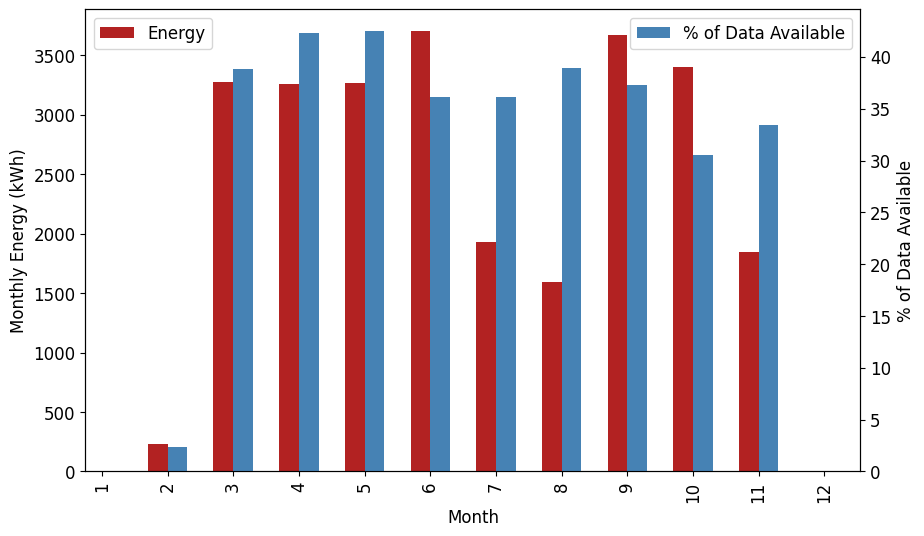

In [74]:
"""
using the parameter name, this cell calculates the monthly energy produced and plots it with the % of data that is available in that month
this plot assumes the parameter is power from some inverter, but this could be done with irradiance to view irradiation

"""
param = 'drakerreal/inv19_dc_power' #-----------------------------------> can be any column in df, but since it is summing and dividing by 60, it makes sense for this to be some inverter or irradiance value
availability = []
for month in annual_onemin.index.month.unique().dropna():
    x = 100 * (1-annual_onemin[annual_onemin.index.month == month][param].isna().sum()/len(annual_onemin[annual_onemin.index.month == month][param]))
    availability.append(x)
monthly_energy = (annual_onemin.resample('M').sum()/60).sort_values('month')[param].to_frame()
monthly_energy['Availability'] = availability
monthly_energy.index = monthly_energy.index.month

fig = plt.figure() 
ax = fig.add_subplot(111) 
ax2 = ax.twinx()
monthly_energy.sort_values(by='TmStamp')[param].plot(kind='bar', color='firebrick', ax=ax, width=0.3, position=1, label='Energy')
monthly_energy.sort_values(by='TmStamp')['Availability'].plot(kind='bar', color='steelblue', ax=ax2, width=0.3, position=0, label='% of Data Available')
ax.legend(loc='upper left')
ax2.legend()
ax.set_ylabel('Monthly Energy (kWh)')
ax2.set_ylabel('% of Data Available')
ax.set_xlabel('Month')

Text(0.5, 0, 'Azimuth')

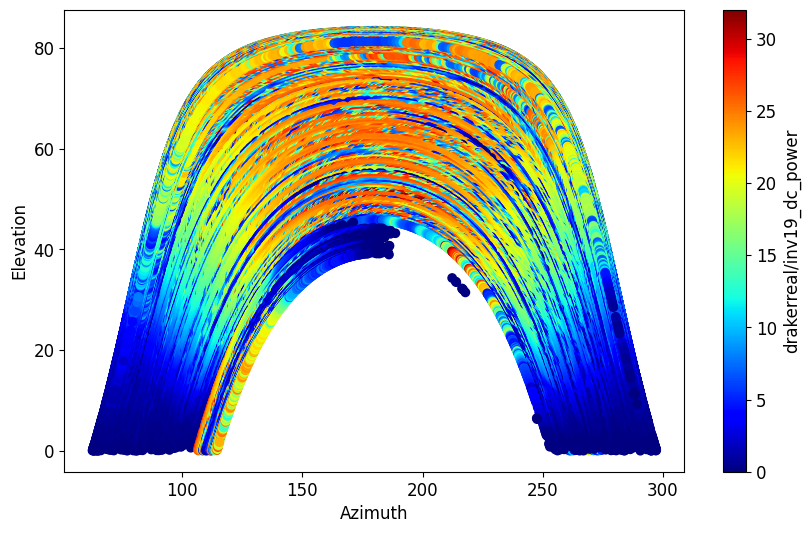

In [85]:
"""
sunpath diagram shows the position of the sun throughout the day & the year
using color can show us the behavior of a parameter at different times of day/year
this type of plot can be especially useful if evaluating a model

"""
param = 'drakerreal/inv19_dc_power' #--------------------> this could be any column in the df, other good parameters would be irradiance, aoi, temperature, etc
plt.scatter(x=annual_onemin['Azimuth'], y=annual_onemin['Elevation'], c=annual_onemin[param], cmap='jet')
clb = plt.colorbar()
clb.ax.set_ylabel(param)
plt.ylabel('Elevation')
plt.xlabel('Azimuth')


Text(0.5, 0, 'Azimuth')

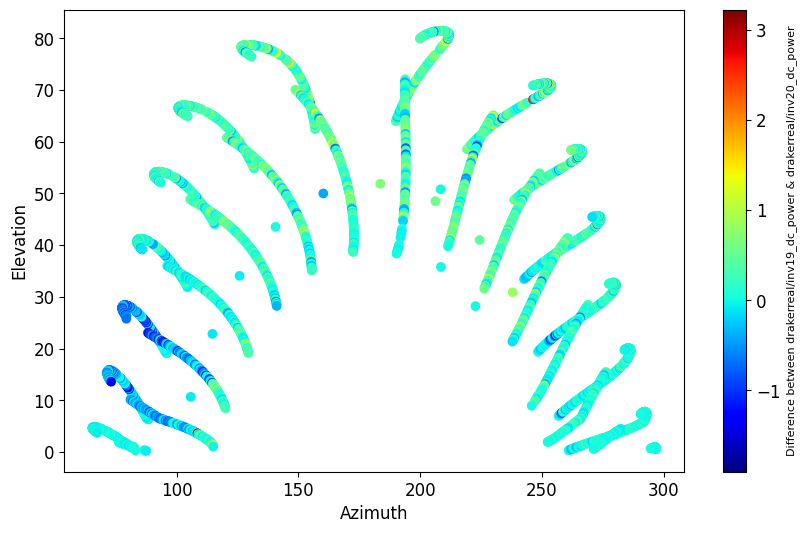

In [89]:
"""
resampling into hourly data turns a sunpath diagram into an analemma diagram (this appears incomplete since there isnt an entire full year of data)
below color represents the difference between two polycrystalline inverters
this can be useful when determining variation between inverter performance due to factors like shading, soiling, array position, outages, etc

"""
param_1 = 'drakerreal/inv19_dc_power' #--------------> could be any parameters in the df, since the plot is showing the difference, they should be the same units
param_2 = 'drakerreal/inv20_dc_power' #-------------> try using different kinds of irradiance to see if one becomes greater at specific times of day/year
annual_onemin.resample('H').mean()
param = 'drakerreal/inv19_dc_power'
plt.scatter(x=annual_onemin.resample('H').mean()['Azimuth'], y=annual_onemin.resample('H').mean()['Elevation'], c=(annual_onemin.resample('H').mean()[param_1] - annual_onemin.resample('H').mean()[param_2]), cmap='jet')
clb = plt.colorbar()
clb.ax.set_ylabel('Difference between '+param_1+' & '+param_2, fontsize=8)
plt.ylabel('Elevation')
plt.xlabel('Azimuth')


(0.0, 24.0)

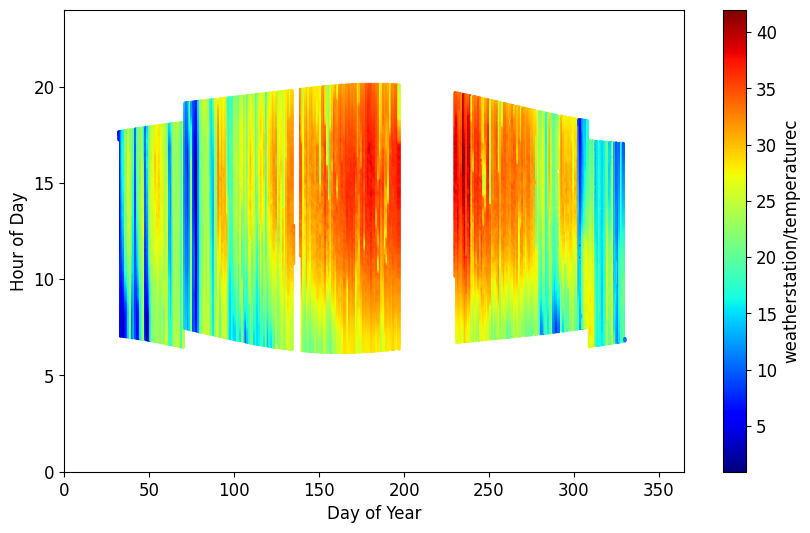

In [174]:
"""
we can plot the data for every minute for every day of the year using color to show some parameter
this helps with detecting dst shifts, which i left unresolved to serve as an example
if there were no missing data the shape would be smooth
if there is an object causing consistent, year-round, shading (mountains, pole, etc) its shape will appear in this plot 

"""
param = 'weatherstation/temperaturec' #----------------> can be any parameter in the df, like weatherstation/planeofarray

annual_onemin['doy'] = annual_onemin.index.strftime('%j')
annual_onemin['doy'] = pd.to_numeric(annual_onemin['doy'], errors='coerce')
annual_onemin['mod'] =((annual_onemin.index.hour*60) + annual_onemin.index.minute)/60
plt.scatter(x=annual_onemin['doy'], y=annual_onemin['time'], c=annual_onemin[param], cmap='jet',s=1)
clb = plt.colorbar()
clb.ax.set_ylabel(param)
plt.ylabel('Hour of Day')
plt.xlabel('Day of Year')
plt.xlim(0,365)
plt.ylim(0,24)

Text(0.5, 0, 'Hour of Day')

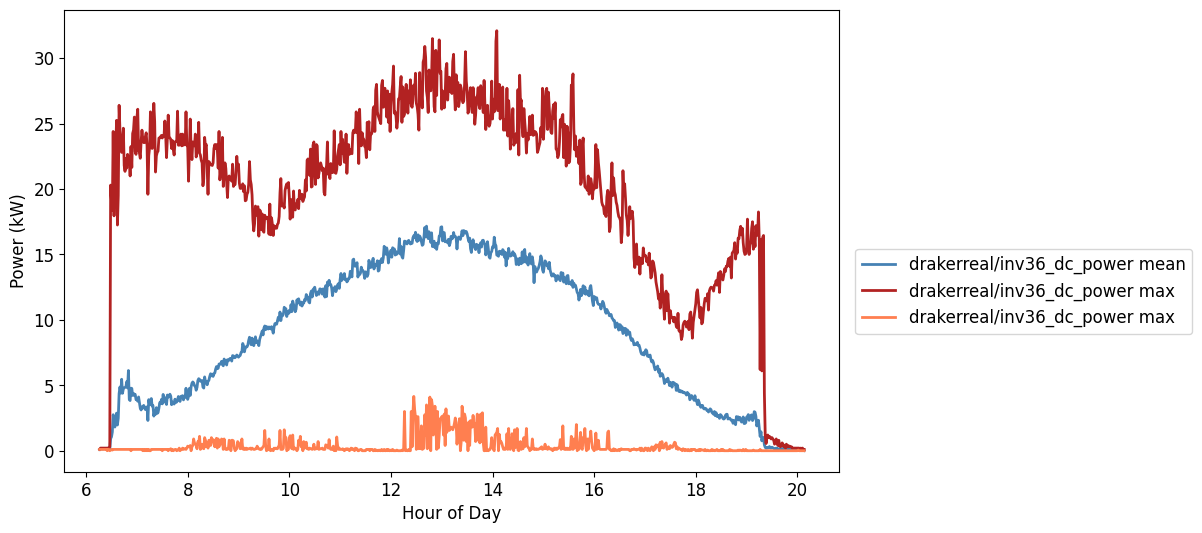

In [190]:
"""
this plot shows the average, maximum, and minimum daily performance of a parameter 
it considers all available data within the year to plot the average days + max/min
"""

fig, ax = plt.subplots()
param = 'drakerreal/inv36_dc_power'
annual_onemin.groupby(annual_onemin['mod'])[param].mean().plot(ax=ax, label=(param+' mean'), linewidth=2, color='steelblue')
annual_onemin.groupby(annual_onemin['mod'])[param].max().plot(ax=ax, label=(param+' max'), linewidth=2, color='firebrick')
annual_onemin.groupby(annual_onemin['mod'])[param].min().plot(ax=ax, label=(param+' max'), linewidth=2, color='coral')
ax.legend(bbox_to_anchor=[1.01,0.5])
plt.ylabel('Power (kW)')
plt.xlabel('Hour of Day')